---
Preparing GFF file into df_indexed. 

In [190]:
file_gff = '/ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3'
df_gff   = pd.read_csv(file_gff,sep='\t',skiprows=2,header=None)

# For CRE
#df_gff['genename'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))
#df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:4]))


dicT2G      = {} # transcript to genename
df_gff_mRNA = df_gff[(df_gff[2] == 'mRNA')]
def get_genename(x):
    if x[2] == 'gene':
        return None
    key   = [y.split('=')[0] for y in x[8].split(';')]
    value = [y.split('=')[1] for y in x[8].split(';')]
    dic   = dict(zip(key,value))
    return dic['Parent']
def get_transcript(x):
    
    
    key   = [y.split('=')[0] for y in x[8].split(';')]
    value = [y.split('=')[1] for y in x[8].split(';')]
    dic   = dict(zip(key,value))
    if x[2] == 'gene':
        return None
    elif x[2] == 'mRNA':
        return dic['ID']
    else: 
        return dic['Parent']
df_gff_mRNA['genename']   = df_gff_mRNA.apply(get_genename,axis=1)
df_gff_mRNA['transcript'] = df_gff_mRNA.apply(get_transcript,axis=1)
df_gff_mRNA_ix = df_gff_mRNA.set_index('transcript')
# For ESA
df_gff['transcriptname']  = df_gff.apply(get_transcript,axis=1)



def get_genename2(x):
    if x != None:
        return df_gff_mRNA_ix.loc[x]['genename']
    else:
        return None
df_gff['genename'] = df_gff['transcriptname'].apply(get_genename2)



# grep longest transcript names
df_gff_mRNA_ix['longest'] = df_gff_mRNA_ix[8].apply(lambda x : x.split(';')[3].replace('longest=',''))
#df_gff_mRNA_index =  df_gff_mRNA.set_index('transcript')

def get_longest(x):
    if x == None:
        return None
    try:
        return df_gff_mRNA_ix.loc[x]['longest']
    except KeyError:
        return None
df_gff['longest'] = df_gff['transcriptname'].apply(get_longest)

df_gff_index = df_gff.set_index(['genename','longest'])

df_gff_index.head()

IOError: File /ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3 does not exist

In [60]:
df_gff_index.to_pickle(file_gff+'.pandas.df.pk')

---

**START**

In [1]:
import sys
sys.path.append('/ref/analysis/pipelines/')
import pandas as pd
import subprocess
import re
from __future__ import print_function
import numpy as np
from IPython.display import SVG, display
import kang


In [2]:
df_gff_index = pd.read_pickle('/ref/analysis/pipelines/pandas_df/Creinhardtii_281_v5.5.gene.gff3.pandas.df.pk')
#df_gff_index = pd.read_pickle('/ref/analysis/pipelines/pandas_df/Esalsugineum_173_v1.0.gene.gff3.pandas.df.pk')

In [3]:
file_fa = '/ref/analysis/DroughtNet/References/Creinhardtii/Creinhardtii_281_v5.0.fa'
dic_fa  = kang.Fasta2dic(file_fa)

In [4]:
df_gff_ix = df_gff_index.reset_index().set_index(['genename','longest',2])

In [5]:
df_gff_ix.sortlevel(inplace=True)

In [6]:
df_gff_ix.head()

0             1      3      4  5  6  7  \
genename longest 2                                                         
NaN      NaN     gene  chromosome_1  phytozomev10  18766  20237  .  +  .   
                 gene  chromosome_1  phytozomev10  20356  23957  .  +  .   
                 gene  chromosome_1  phytozomev10  24026  30617  .  +  .   
                 gene  chromosome_1  phytozomev10  30776  41037  .  +  .   
                 gene  chromosome_1  phytozomev10  41896  46547  .  +  .   

                                                              8 transcriptname  
genename longest 2                                                              
NaN      NaN     gene  ID=Cre01.g000017.v5.5;Name=Cre01.g000017           None  
                 gene  ID=Cre01.g000033.v5.5;Name=Cre01.g000033           None  
                 gene  ID=Cre01.g000050.v5.5;Name=Cre01.g000050           None  
                 gene  ID=Cre01.g000100.v5.5;Name=Cre01.g000100           None  
                 gene  ID=Cre01.g000150.v5.5;Name=Cre01.g000150           None

In [277]:
genelist = list(set(df_gff_ix.index.get_level_values('genename')))

In [23]:
# global vars.
genename                = 'Cre01.g005651.v5.5' # GAGAAGGAGGAGGGGAAGGT	ACCTTCCCCTCCTTCTCCTC
strand                  = df_gff_ix.loc[(genename,'1','mRNA')][6].values[0]
primers = '''TATGAGCTTGCCACGCTCAA	CCACCAGTGTAGCAGACAGG
GGAGTTCCAGAAGCAGCACT	CATTGTTGTTCACAGCCGCA'''
primerlist              = [x.split('\t') for x in primers.split('\n')]
#genename               = 'Thhalv10024217m.g.v1.0'
chromosome, left, right = df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values[0]
geneseq                 = dic_fa[chromosome][left-1:right]
bamlist                 = ['/ref/analysis/Cre/tophat/merge_all/merge.all.bam','/ref/analysis/Cre/tophat/sulfur/merge/SRP002284.sulfur.merged.bam','/ref/analysis/Cre/tophat/nitrogen/merge/nitrogen.merged.bam']
#bamlist                = ['/ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam','/ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam']
outfilename             = genename+'.bamvisgene.svg'
Outfile                 = open(outfilename,'w')

In [24]:
# alignment vars.
each_height   = 5
each_space    = 2
box_height    = 3
bridge_height = 2
genestart     = 3
total_canvas_rows = 10 # 2 for gene model 
canvas_width      = 1000
canvas_height     = (total_canvas_rows + 10)*(each_height+each_space)*len(bamlist)
real_width        = right-left+1+100+100


#svg configure 
rect = '<rect x="%d" y="%d" width="%d" height="%d" style="fill:%s;stroke:%s;stroke-width:1;fill-opacity:0.8;stroke-opacity:0.3" />'
line = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="%d" />'
text = '<text x="%d"  y="%d" style="font-family:Arial;font-size:%d;stroke:black;fill:black;">%s</text>'

In [364]:
primerlist
#strand

[['TATGAGCTTGCCACGCTCAA', 'CCACCAGTGTAGCAGACAGG'],
 ['GGAGTTCCAGAAGCAGCACT', 'CATTGTTGTTCACAGCCGCA']]

In [365]:
init_svg()
endp = draw_gene(5,genename_list[0],len(genename_list))
#endp = draw_primer(endp,primerlist)
#endp = draw_words(endp,'Primers')
endp = draw_alignment_1(endp,bamlist[0])
endp = draw_words(endp,bamlist[0].split('/')[-1])
endp = draw_alignment_1(endp,bamlist[1])
endp = draw_words(endp,bamlist[1].split('/')[-1])
end_svg()


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


samtools view /ref/analysis/Cre/tophat/merge_all/merge.all.bam chromosome_1:999817-1003518 > temp.sam


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


samtools view /ref/analysis/Cre/tophat/sulfur/merge/SRP002284.sulfur.merged.bam chromosome_1:999817-1003518 > temp.sam


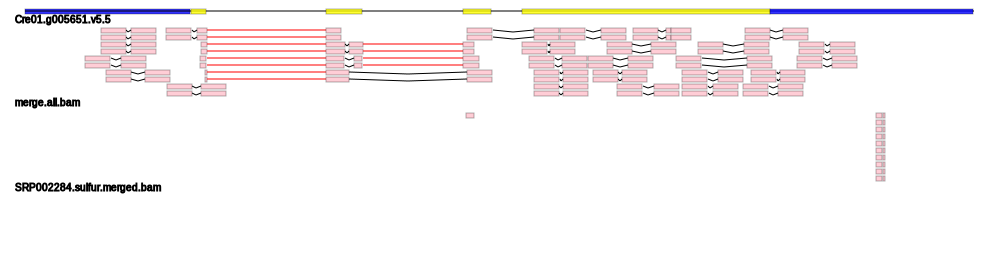

In [366]:
display(SVG(genename+'.bamvisgene.svg'))

In [367]:
df_gff_ix.loc['Cre01.g005651.v5.5']

0             1        3        4  5  6  \
longest 2                                                                     
1       CDS              chromosome_1  phytozomev10  1000464  1000526  .  +   
        CDS              chromosome_1  phytozomev10  1000992  1001134  .  +   
        CDS              chromosome_1  phytozomev10  1001527  1001638  .  +   
        CDS              chromosome_1  phytozomev10  1001755  1002723  .  +   
        five_prime_UTR   chromosome_1  phytozomev10   999817  1000463  .  +   
        mRNA             chromosome_1  phytozomev10   999817  1003518  .  +   
        three_prime_UTR  chromosome_1  phytozomev10  1002724  1003518  .  +   

                         7                                                  8  \
longest 2                                                                       
1       CDS              0  ID=Cre01.g005651.t1.1.v5.5.CDS.1;Parent=Cre01....   
        CDS              0  ID=Cre01.g005651.t1.1.v5.5.CDS.2;Parent=Cre01....   
        CDS              1  ID=Cre01.g005651.t1.1.v5.5.CDS.3;Parent=Cre01....   
        CDS              0  ID=Cre01.g005651.t1.1.v5.5.CDS.4;Parent=Cre01....   
        five_prime_UTR   .  ID=Cre01.g005651.t1.1.v5.5.five_prime_UTR.1;Pa...   
        mRNA             .  ID=Cre01.g005651.t1.1.v5.5;Name=Cre01.g005651....   
        three_prime_UTR  .  ID=Cre01.g005651.t1.1.v5.5.three_prime_UTR.1;P...   

                                  transcriptname  
longest 2                                         
1       CDS              Cre01.g005651.t1.1.v5.5  
        CDS              Cre01.g005651.t1.1.v5.5  
        CDS              Cre01.g005651.t1.1.v5.5  
        CDS              Cre01.g005651.t1.1.v5.5  
        five_prime_UTR   Cre01.g005651.t1.1.v5.5  
        mRNA             Cre01.g005651.t1.1.v5.5  
        three_prime_UTR  Cre01.g005651.t1.1.v5.5

In [ ]:
genelist                =  ['Cre01.g004200.v5.5', 'Cre01.g004250.v5.5', 'Cre01.g004300.v5.5']
genename                = '.'.join(genelist)
outfilename             = genename+'.bamvisgene.svg'
Outfile                 = open(outfilename,'w')
loc                     = []
for i,genename in enumerate(genelist):
    chromosome, left, right = df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values[0]
    loc.append(left)
    loc.append(right)
loc.sort()
left                    = loc[0]
right                   = loc[-1]
print(left, right)
real_width              = right-left+200
init_svg()
for genename in genelist:
    endp = draw_gene(5,left,right,genename)
endp = draw_alignment_2(endp,chromosome,left,right,bamlist[0])
endp = draw_alignment_2(endp,chromosome,left,right,bamlist[1])
endp = draw_alignment_2(endp,chromosome,left,right,bamlist[2])
end_svg()


826413 841428
samtools view /ref/analysis/Cre/tophat/merge_all/merge.all.bam chromosome_1:826413-841428 > temp.sam


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


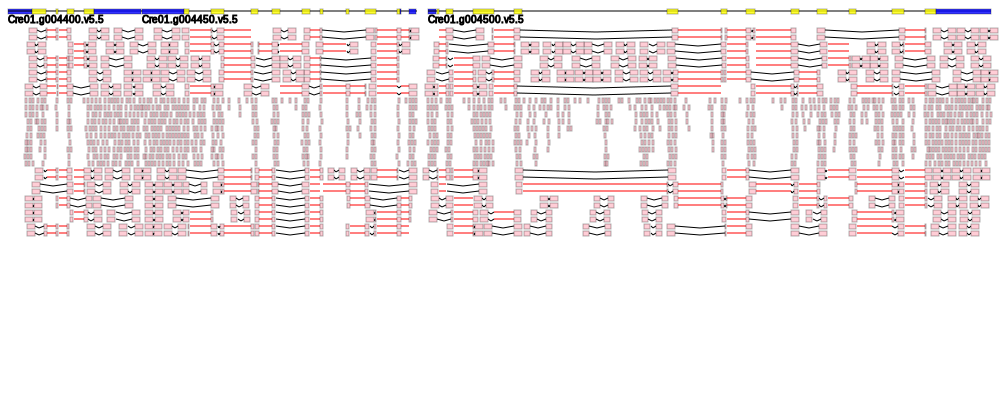

In [41]:
display(SVG('Cre01.g004400.v5.5.Cre01.g004450.v5.5.Cre01.g004500.v5.5.bamvisgene.svg'))

samtools view /ref/analysis/Cre/tophat/merge_all/merge.all.bam chromosome_1:46427-77233 > temp.sam


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
samtools view /ref/analysis/Cre/tophat/sulfur/merge/SRP002284.sulfur.merged.bam chromosome_1:46427-77233 > temp.sam
samtools view /ref/analysis/Cre/tophat/nitrogen/merge/nitrogen.merged.bam chromosome_1:46427-77233 > temp.sam
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!
pass!


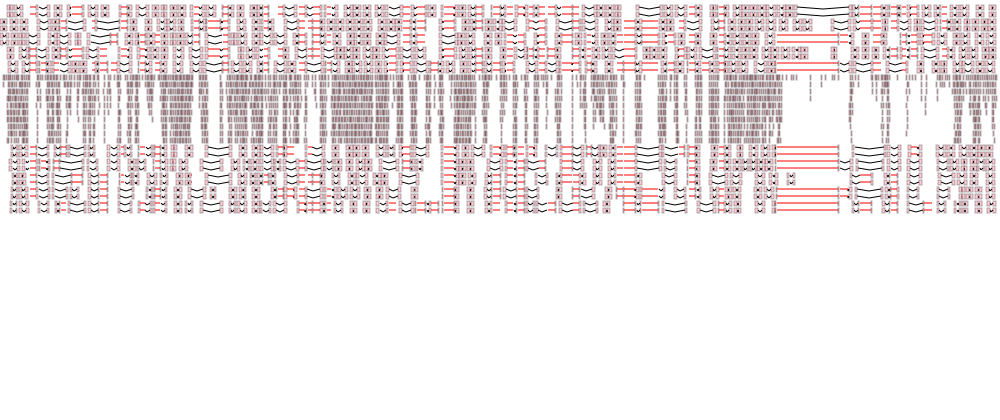

In [422]:
genename                = 'test'
outfilename             = genename+'.bamvisgene.svg'
Outfile                 = open(outfilename,'w')
chromosome              = 'chromosome_1'
left                    = 46427 
right                   = 77233
real_width              = right-left+200
init_svg()
endp = draw_alignment_2(5,chromosome,left,right,bamlist[0])
endp = draw_alignment_2(endp,chromosome,left,right,bamlist[1])
endp = draw_alignment_2(endp,chromosome,left,right,bamlist[2])
end_svg()
display(SVG('test.bamvisgene.svg'))

In [385]:
df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values


array([['chromosome_1', 1748305, 1759279]], dtype=object)

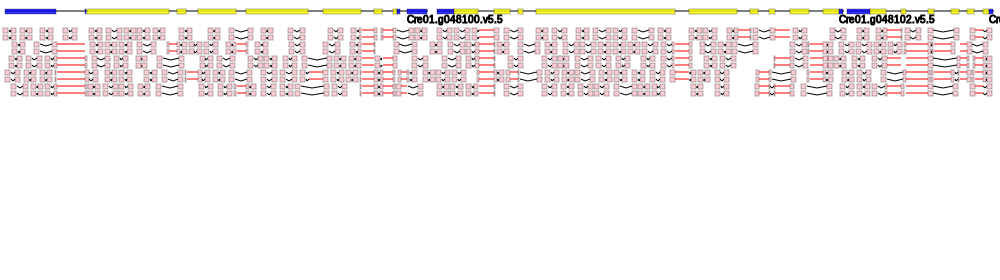

In [395]:
display(SVG('test.bamvisgene.svg'))

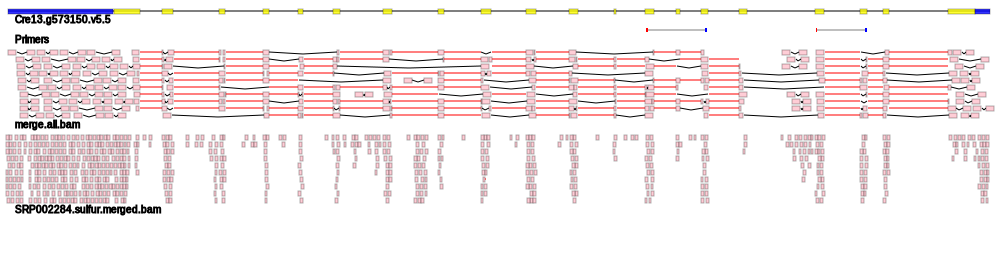

In [156]:
display(SVG('Cre13.g573150.v5.5.bamvisgene.svg'))

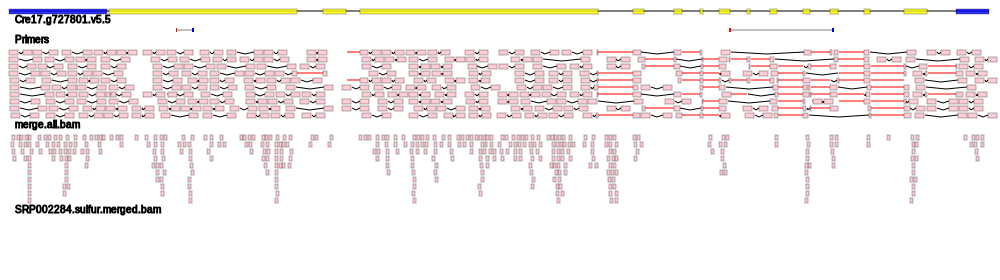

In [151]:
display(SVG('Cre17.g727801.v5.5.bamvisgene.svg'))

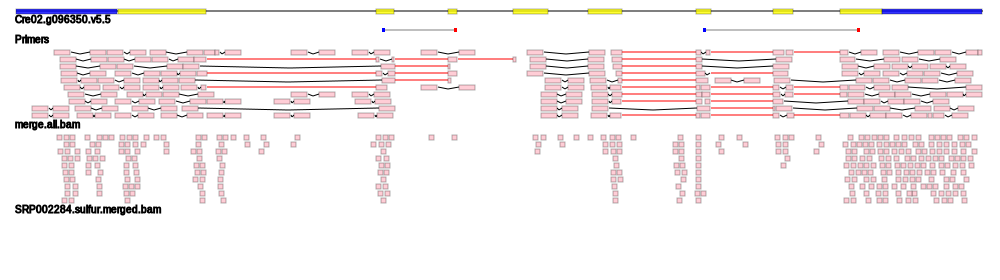

In [130]:
display(SVG('Cre02.g096350.v5.5.bamvisgene.svg'))

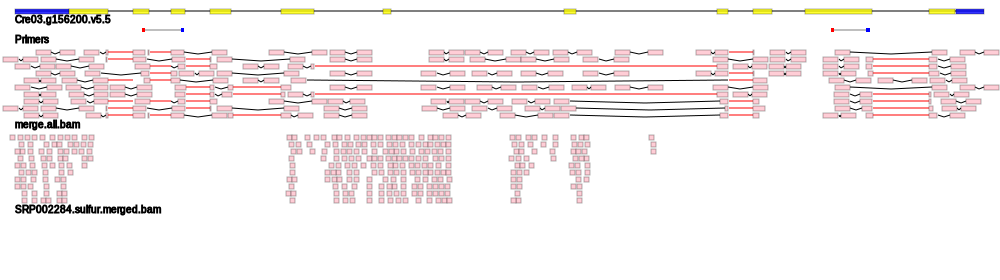

In [124]:
display(SVG('Cre03.g156200.v5.5.bamvisgene.svg'))

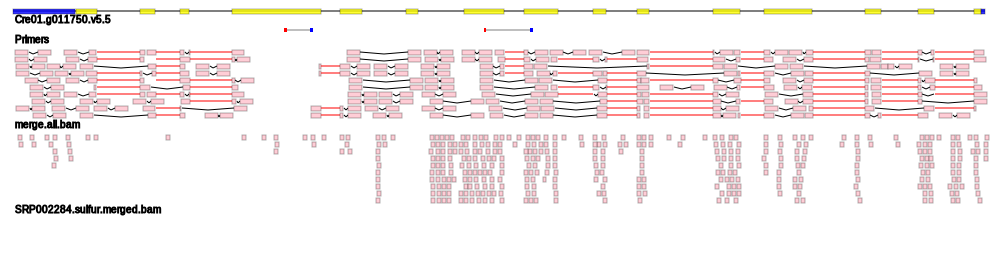

In [125]:
display(SVG('Cre01.g011750.v5.5.bamvisgene.svg'))

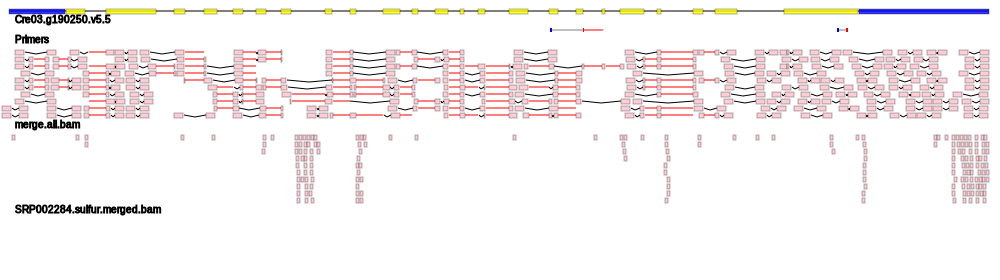

In [115]:
display(SVG('Cre03.g190250.v5.5.bamvisgene.svg'))

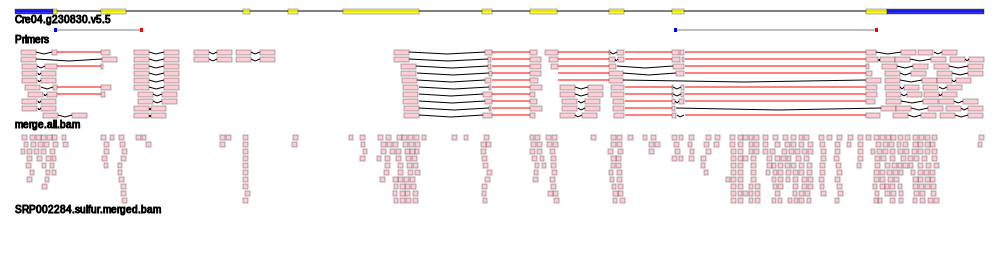

In [110]:
display(SVG('Cre04.g230830.v5.5.bamvisgene.svg'))

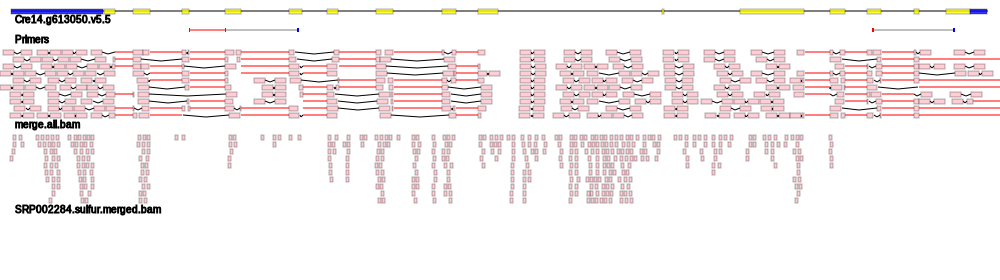

In [105]:
display(SVG('Cre14.g613050.v5.5.bamvisgene.svg'))

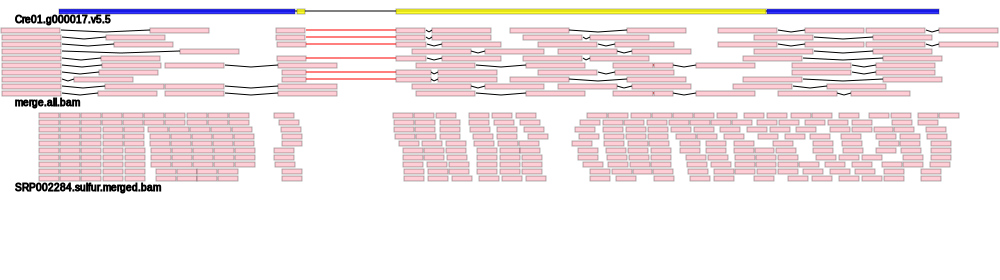

In [84]:
display(SVG('Cre01.g000017.v5.5.bamvisgene.svg'))

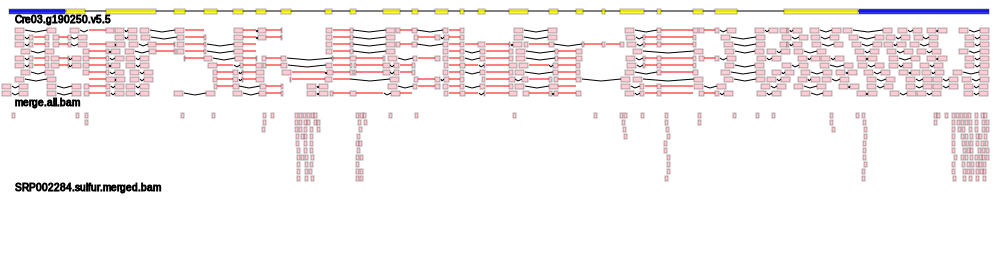

In [85]:
display(SVG('Cre03.g190250.v5.5.bamvisgene.svg'))

In [8]:
def init_svg():   
    print('''<svg height="%d" width="%d">'''%(canvas_height,canvas_width),file=Outfile)
def end_svg():
    print('''</svg>
    ''',file=Outfile)

    Outfile.close()

In [9]:
def get_ratio(x):
    return int(float(x)/float(real_width) * canvas_width)

In [10]:
def draw_words(y,strWord):
    print(text%(15,y+8,10,strWord),file=Outfile)
    return y+8+each_space+5

In [11]:
def draw_gene(start_height,left,right,genename):
    df = df_gff_ix.loc[(genename,'1')]
    df = df.reset_index()
    df = df.sort(3)

    fill_CDS   = 'yellow'
    strock_CDS = 'black'

    fill_UTR   = 'blue'
    strock_UTR = 'black'

    for i in df.index:
        if df.loc[i][2] == 'mRNA':
             
            x1     = get_ratio(df.loc[i][3] - left + 100)
            text_x = x1
            y1     = start_height + int(each_height/2) + genestart + 1
            x2     = get_ratio(df.loc[i][4] - left + 100)
            y2     = start_height + int(each_height/2) + genestart + 1
            print(line%(x1,y1,x2,y2,'black',1),file=Outfile)
        elif 'UTR' in df.loc[i][2]:
            x1 = get_ratio(df.loc[i][3] - left + 100)
            y1 = start_height + genestart + 1 
            w  = get_ratio(df.loc[i][4] - df.loc[i][3])
            h  = each_height
            print(rect%(x1,y1,w,h,fill_UTR,strock_UTR),file=Outfile)
        elif 'CDS' in df.loc[i][2]:
            x1 = get_ratio(df.loc[i][3] - left + 100)
            y1 = start_height + genestart + 1
            w  = get_ratio(df.loc[i][4] - df.loc[i][3])
            h  = each_height
            print(rect%(x1,y1,w,h,fill_CDS,strock_CDS),file=Outfile)

    print(text%(text_x,genestart+each_height*4,10,genename),file=Outfile)
    return start_height + genestart+each_height*4

In [12]:
def match_count(a,b):
        count = 0
        if len(a)!=len(b):
            #print('not same length')
            #print (a)
            #print (b)
            return None 
        else:
            for n,i in enumerate(a):
                if a[n] == b[n]:
                    count += 1
                if a[n] != b[n]:
                    break 
        return count
def match_list(primer):
    i = 0
    j = 0 
    match_list = []
    primer_seq = primer 
    print('#',primer)
    while j < len(geneseq):
        i = 0
        inseq = geneseq[j:]
        mc_list = []
        while i != len(inseq):
            mc = match_count(inseq[i:i+len(primer_seq)],primer_seq)
            mc_list.append([i,mc])
            #print(i,len(inseq))
            i += 1
        loc,mc = max(mc_list,key=lambda x:x[1])
        match_list.append([j+loc,j+loc+mc])
        j = j + loc + mc
        
        print(primer_seq[0:mc])
        primer_seq = primer_seq[mc:]
        if primer_seq == '':
            break
        print(primer_seq)
    return match_list
    


In [13]:
match_list('ACCTTCCCCTCCTTCTCCTC')

# ACCTTCCCCTCCTTCTCCTC


NameError: global name 'geneseq' is not defined

In [14]:
geneseq[1916:1928]

NameError: name 'geneseq' is not defined

In [15]:
len('GATATTATGGTTTGCTTATGAGAACTACTGTCTCGCGTGGACACTGCTTCCATCTTGTTTAGCTTTGCGACTACTCAACACCATGCCCTTCAGGATACCATGAAGGATACGCATTTATGAATCCGGTTTTGCCAAAGGATATTACAAGCGTCGCAGGTACCGCAGCTGCGGAATGGCCGCGGGCACTCTCGCTGACTCAACCCTCCTGCATTACACTTAACAACATGTAATGTTAGCATACAGCGCATGTCTTCTTGAGAGCCGTGGCTAGCTCCAGGCGTTGTCCCATTCCGCTGCGGGCATGCCGGCCCCGGTTTGGGTGCTCGACGCGGCTGCACCGGCGTCGGGTTCAGAGTCAGCTGATCAGCAGAAAAGCTCTGGCGAGCCGCCGTCGCCGTCGCGCCTGCGGCAGGGTGCGCTTAAGGGCTCCAGCCTGCTGCAGCTCGACCTGCATGGCCAGGGCCCCTCCTCGCAGGCGGCGGCACCCGCCGTGAGCGGCCCCGCGTCCCCCGCGACTGCGGCAGCGCAGTGGAAGCCGGCGAGCAGCTTCAAGTCCCTGGCTGGCCCCGAAGGCTTCGGCACCCCCGGCAGCCAGCAGCCACACCCAGGGCTGCTGCTCTCCCTGCTCTCCGCCGCCCGCGCCCCAGGGGCTGCGGCTGTAGCAGGCCGCACCTCGCCCCAGCACGCGGGTGCTGCAGCTACAGCTCCTGCTGCTGCTACTGCATCCCCCCCCACTGCCACTGCTGCCGGAGCCGGAGGCGGAGCCGGGCCCGGCAGGCGGGCAGCGGGCGCGGGCGCAGGCGCCAGCGCCACCTCCCCGCCGCGCATCGGCGCCGCTGCCGCGGCGGCCGCGCTCACAGGCCCACCCACAGCGCCCTTCTCCTACAGCCCACTGCTTCCGCCCCACCACCAGAACGGACAGTCCCGCAGCGGGGCCAGCGTTCCTGCCGGCAGCGGGGCCGGCACCAGCACCAGCCCTAGGATTGGCGCCGGCGCCGGCGCTAGGGCTGCTCAGAACGGGCAGAACGGGGGAGGAGGAGGGAGTTCAGCCGGGCTGCCGCCGTCCGCGCTGAGGGTGGCCGACGGCGGCGACGTGCGGAGAGGCAGTGGCGGCGGTGCTGGCGGTGCCGGCGGCTCTGCCGCCGGTGGCGGCGCCGCAGGGGCCCGCCAGACAGCGGCCGGGCGGTCGCATGGGCCGCTGCCGCCGGCGCCGCCGCCGGCCTACTACCTGTCATCCGGCGCTGCAGCGGGGGCGGCGGCGGCGACAGGGGTGCGCTACCCCAGCCCTCCGGTCACGGCATCCTCCGGCGGCAGCGGCGGCGCCGATGCGGACTCGGCGTTTGAGTACCTGGGTGCTTATGAGGAGGACGCGCCGAGTGGCGAGGACGAGGAGGCGGAGGAGGAGGCGGAGGGCGAGGAGGAGGCGGAGGGTGAGGAGGGGGAAGCCAGTAGCTCAGAGGGCGGGCAGGACAGCGATGCCGATGAGGAAGGGGAGGGAGAGGAGGAGGATGGGGAGGAGCAAGGAGGTGCAAAGCGGCTGGGACGTCACTGGCAGCAGCAGCAGCAGCAACAGCAGCAGCAGTTGCCGCAGCGGCCGCCGGCGCGGCAGCAGGTGCGGCCGGCGGCGCCGGCGGTTGGTTCGCGTCCAGGCGCGGCAGTAGGCACGGCGGCGGCCGGGAGCCGCTTGTCGGCACAGGCACAGGCTGTAGCAGCTGCCAAGGTGGCAGCCGCCGTCAACGCCGCCAGATCCGGCGGCGCGCCGCTGCGTGTGTTGCTGCAGACCTCGGTCTCCCCAACACTGCAGATGCAGCGCCCGCCCAGCGGTGGTGGCGGTGGTGGTGGAGGCGGTGGAGGCGGTCGCCAGCCGCCGCCGCTGCCGCCCAGCCTGCAGCAGCTGCAACTGCAGCACCAGCAGGCGCTGGCGGCGCTGGGCGCTGGATCTGGATTTGGATTCGGGCCGGGGTACGCGCCTGGTTCTGGGTTGGGACCTGGATCTGGATCCGGAGTGGGATCGGGCGCGGACAACCCGGTTCTGGCAGCCTACGCGGCGGCCACGGCGTTTCCGCCGCCTGCCCACCAGCCGCAGCAGCAGCAACAGCAACAGCAGCGTGGCGGGTA')

2118

In [16]:
def draw_primer(start_height,primerlist):
    for strF,strR in primerlist:
        if strand == '+':
            strR = kang.rev_comp(strR)        
        else:
            strF = kang.rev_comp(strF)
        x_list = []
        for x1,x2 in match_list(strF):
            x_list.append(x1)
            x_list.append(x2)
            y1 = start_height + int(each_height/2)
            y2 = start_height + int(each_height/2)
            print(line%(get_ratio(x1+100),y1,get_ratio(x2+100),y2,'blue',4),file=Outfile)
        x_list.sort()
        print(line%(get_ratio(x_list[0]+100),y1,get_ratio(x_list[-1]+100),y2,'blue',1),file=Outfile)
        x_list_2 = []
        for x3,x4 in match_list(strR):
            x_list_2.append(x3)
            x_list_2.append(x4)
            y1 = start_height + int(each_height/2)
            y2 = start_height + int(each_height/2)
            print(line%(get_ratio(x3+100),y1,get_ratio(x4+100),y2,'red',4),file=Outfile)
        x_list_2.sort()
        print(line%(get_ratio(x_list_2[0]+100),y1,get_ratio(x_list_2[-1]+100),y2,'red',1),file=Outfile)
        if strand == '+':
            print(line%(get_ratio(x_list[-1]+100),y1,get_ratio(x_list_2[0]+100),y2,'gray',1),file=Outfile)
        else: print(line%(get_ratio(x_list_2[-1]+100),y1,get_ratio(x_list[0]+100),y2,'gray',1),file=Outfile)
    return y2 + each_height

In [17]:
kang.rev_comp('CGTTGCCCTTGGTGAAGTTG')

'CAACTTCACCAAGGGCAACG'

In [18]:
def draw_alignment_1(start_height,file_bam):
    gene_space        = np.zeros([total_canvas_rows,real_width])
    print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-10 temp.sam > temp.sam.cut',shell=True)
    df_sam = pd.read_csv('temp.sam.cut',sep='\t',header=None)
    df_sam['SRRID']  = df_sam[0].apply(lambda x:x.split('.')[0])
    df_sam['READID'] = df_sam[0].apply(lambda x:x.split('.')[1])
    try:
        df_sam['PAIRID'] = df_sam[0].apply(lambda x:x.split('.')[2])
        bPaired = 1
    except IndexError:
        bPaired = 0

    mask = (df_sam[8] > 0)
    df_sam_forward = df_sam[mask]
    df_sam_forward = df_sam_forward.sort(3)
    READID_LIST    = df_sam_forward['READID']
    if bPaired == 1:
        df_sam_index = df_sam.set_index(['SRRID','READID','PAIRID'])
    else: 
        df_sam_index = df_sam.set_index(['SRRID','READID'])
    df_sam_index = df_sam_index.sort([3])
    df_sam_index.sortlevel(inplace=True)

    def cigar_parse(cigar):
        match = re.findall(r'(\d+)(\w)', cigar)
        return match
    SRRID_list = set(df_sam_index.index.get_level_values('SRRID'))
    readnumber = 0
    bPass = 1
    for SRRID in SRRID_list:
        READID_list = df_sam_index.loc[SRRID].index.get_level_values('READID')
        for READID in READID_list:
            #print(READID)
            if bPaired == 1:  
                df = df_sam_index.loc[(SRRID,READID)]
                if len(df) == 2:
                    pass
                else: continue
            else:
                if len(df_sam_index.loc[(SRRID,READID)]) < 10: # in the case of multiple match. Just select first one ...
                    df = df_sam_index.loc[(SRRID,READID)].values[0]
                else:
                    df = df_sam_index.loc[(SRRID,READID)].values
            ##################################### cigar check start
            gap_length = 0
            match_length = 0
            if bPaired == 1:
                for cigar in df[5]:
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM]
                    for i, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'N' or cigarstring == 'I':
                            gap_length += int(cigarvalues[i])
                        if cigarstring == 'M':
                            match_length += int(cigarvalues[i])
            else:
                try:
                    cigarM       = cigar_parse(df[5])
                except IndexError:
                    print(df) # Sanity check 
                cigarstrings = [x[1] for x in cigarM]
                cigarvalues  = [x[0] for x in cigarM]
                for i, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'N' or cigarstring == 'I':
                        gap_length += int(cigarvalues[i])
                    if cigarstring == 'M':
                        match_length += int(cigarvalues[i])

            #print(gap_length,match_length)
            if bPaired == 1:
                fragstart      = min(df[3])-left+100
            else:
                #print (df)
                fragstart    = df[3]-left+100
            if fragstart < 0:
                continue
            if bPaired == 1:
                fragmentsize   = max(df[8])
                fragmentsize_r = min(df[8])
                insertsize     = fragmentsize - gap_length - 200
            if bPaired == 1:
                if insertsize < 10:
                    continue
                if fragmentsize_r > 0 :
                    continue
            else: pass
            ##################################################################### Error remove
            
            ##################################################################### making fast start
            #if bPaired == 1:
            #    flatten = np.sum(gene_space[:,fragstart:fragstart+fragmentsize],axis=0)
            #    if max(flatten) == total_canvas_rows:
            #        continue
            #else:
            #    flatten = np.sum(gene_space[:,fragstart:fragstart+match_length+gap_length],axis=0)
            #    if max(flatten) == total_canvas_rows:#total_canvas_rows * (match_length+gap_length) :
            #        continue
            ##################################################################### making fast end
            srow = None
            for nrow, row in enumerate(gene_space):
                #if nrow <= 3:
                #    continue
                if bPaired == 1:
                    if max(row[fragstart:fragstart+fragmentsize]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+fragmentsize] += 1
                        break
                else:
                    #print(fragstart)
                    if max(row[fragstart:fragstart+match_length+gap_length]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+match_length+gap_length] += 1
                        break

            if srow == None:
                continue
            #print(srow)
            ##################################################################### Row selection 
            readnumber = srow
            #print(readnumber)
            if bPaired == 1:
                for i in df.index:
                    fragsize          = df.loc[i][8]
                    startpoint        = df.loc[i][3]
                    secondstartpoint  = df.loc[i][7]
                    cigar        = df.loc[i][5]
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM] 
                    ##################################################################
                    coverleng = 0
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M' or cigarstring == 'N' or cigarstring == 'I':
                            coverleng += int(cigarvalues[j])
                    if fragsize > 0:
                        x1 = get_ratio(startpoint - left + 100 + coverleng)
                        y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)

                        y2 = start_height + readnumber * (each_height + each_space) + int(each_height/2) + int(each_height/2)
                        x3 = get_ratio(secondstartpoint - left + 100)
                        x2 = (x3 + x1)/2
                        print(line%(x1,y1,x2,y2,'black',1),file=Outfile)
                        print(line%(x2,y2,x3,y1,'black',1),file=Outfile)

                    ################################################################# paired end line
                    #print(i)
                    w = 0
                    #print (cigarstrings)
                    #print (cigarvalues)
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M':
                            x = get_ratio(w + startpoint - left + 100)
                            #print(x)
                            if x < 0:
                                continue
                            y = start_height + readnumber * (each_height + each_space)

                            h = int(each_height)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            #print(x,y,w,h)
                            print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                        elif cigarstring == 'N' or cigarstring == 'I':
                            x1 = get_ratio(w + startpoint - left + 100)
                            if x1 < 0:
                                continue
                            y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            x2 = get_ratio(w + startpoint - left + 100)

                            print(line%(x1,y1,x2,y1,'red',1),file=Outfile)
            else:
                fragsize          = df[8]
                startpoint        = df[3]
                secondstartpoint  = df[7]
                #print(df)
                cigar             = df[5]
                cigarM            = cigar_parse(cigar)
                #print(cigarM)
                cigarstrings      = [x[1] for x in cigarM]
                cigarvalues       = [x[0] for x in cigarM]
                w = 0 
                for j, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'M':
                        x = get_ratio(w + startpoint - left + 100)
                        #print(x)
                        if x < 0:
                            continue
                        y = start_height + readnumber * (each_height + each_space)

                        h = int(each_height)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        #print(x,y,w,h)
                        print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                    elif cigarstring == 'N' or cigarstring == 'I':
                        x1 = get_ratio(w + startpoint - left + 100)
                        if x1 < 0:
                            continue
                        y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        x2 = get_ratio(w + startpoint - left + 100)

                        print(line%(x1,y1,x2,y1,'red',1),file=Outfile)


    return start_height+(each_height + each_space) * len(gene_space)

In [35]:
def draw_alignment_2(start_height,chromosome,left,right,file_bam):
    real_width        = right-left+1+100+100
    gene_space        = np.zeros([total_canvas_rows,real_width])
    print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-10 temp.sam > temp.sam.cut',shell=True)
    df_sam = pd.read_csv('temp.sam.cut',sep='\t',header=None)
    df_sam['SRRID']  = df_sam[0].apply(lambda x:x.split('.')[0])
    df_sam['READID'] = df_sam[0].apply(lambda x:x.split('.')[1])
    try:
        df_sam['PAIRID'] = df_sam[0].apply(lambda x:x.split('.')[2])
        bPaired = 1
    except IndexError:
        bPaired = 0

    mask = (df_sam[8] > 0)
    df_sam_forward = df_sam[mask]
    df_sam_forward = df_sam_forward.sort(3)
    READID_LIST    = df_sam_forward['READID']
    if bPaired == 1:
        df_sam_index = df_sam.set_index(['SRRID','READID','PAIRID'])
    else: 
        df_sam_index = df_sam.set_index(['SRRID','READID'])
    df_sam_index = df_sam_index.sort([3])
    df_sam_index.sortlevel(inplace=True)

    def cigar_parse(cigar):
        match = re.findall(r'(\d+)(\w)', cigar)
        return match
    SRRID_list = set(df_sam_index.index.get_level_values('SRRID'))
    readnumber = 0
    bPass = 1
    for SRRID in SRRID_list:
        READID_list = df_sam_index.loc[SRRID].index.get_level_values('READID')
        for READID in READID_list:
            #print(READID)
            if bPaired == 1:  
                df = df_sam_index.loc[(SRRID,READID)]
                if len(df) == 2:
                    pass
                else: continue
            else:
                if len(df_sam_index.loc[(SRRID,READID)]) < 10: # in the case of multiple match. Just select first one ...
                    df = df_sam_index.loc[(SRRID,READID)].values[0]
                else:
                    df = df_sam_index.loc[(SRRID,READID)].values
            ##################################### cigar check start
            gap_length = 0
            match_length = 0
            if bPaired == 1:
                for cigar in df[5]:
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM]
                    for i, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'N' or cigarstring == 'I':
                            gap_length += int(cigarvalues[i])
                        if cigarstring == 'M':
                            match_length += int(cigarvalues[i])
            else:
                try:
                    cigarM       = cigar_parse(df[5])
                except IndexError:
                    print(df) # Sanity check 
                cigarstrings = [x[1] for x in cigarM]
                cigarvalues  = [x[0] for x in cigarM]
                for i, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'N' or cigarstring == 'I':
                        gap_length += int(cigarvalues[i])
                    if cigarstring == 'M':
                        match_length += int(cigarvalues[i])

            #print(gap_length,match_length)
            if bPaired == 1:
                fragstart      = min(df[3])-left+100
            else:
                #print (df)
                fragstart    = df[3]-left+100
            if fragstart < 0:
                continue
            if bPaired == 1:
                fragmentsize   = max(df[8])
                fragmentsize_r = min(df[8])
                insertsize     = fragmentsize - gap_length - 200
            if bPaired == 1:
                if insertsize < 10:
                    continue
                if fragmentsize_r > 0 :
                    continue
            else: pass
            ##################################################################### Error remove
            
            ##################################################################### making fast start
            if bPaired == 1:
                for i in np.arange(fragstart,fragstart+fragmentsize):
                    try:
                        flatten = np.sum(gene_space[:,i])
                    except IndexError:
                        continue
                if flatten == total_canvas_rows:
                    #print('pass!')
                    continue
            #else:
            #    flatten = np.sum(gene_space[:,fragstart:fragstart+match_length+gap_length],axis=0)
            #    if max(flatten) == total_canvas_rows:#total_canvas_rows * (match_length+gap_length) :
            #        continue
            ##################################################################### making fast end
            srow = None
            for nrow, row in enumerate(gene_space):
                #if nrow <= 3:
                #    continue
                if bPaired == 1:
                    if max(row[fragstart:fragstart+fragmentsize]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+fragmentsize] += 1
                        break
                else:
                    #print(fragstart)
                    if max(row[fragstart:fragstart+match_length+gap_length]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+match_length+gap_length] += 1
                        break

            if srow == None:
                continue
            #print(srow)
            ##################################################################### Row selection 
            readnumber = srow
            #print(readnumber)
            if bPaired == 1:
                for i in df.index:
                    fragsize          = df.loc[i][8]
                    startpoint        = df.loc[i][3]
                    secondstartpoint  = df.loc[i][7]
                    cigar        = df.loc[i][5]
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM] 
                    ##################################################################
                    coverleng = 0
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M' or cigarstring == 'N' or cigarstring == 'I':
                            coverleng += int(cigarvalues[j])
                    if fragsize > 0:
                        x1 = get_ratio(startpoint - left + 100 + coverleng)
                        y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)

                        y2 = start_height + readnumber * (each_height + each_space) + int(each_height/2) + int(each_height/2)
                        x3 = get_ratio(secondstartpoint - left + 100)
                        x2 = (x3 + x1)/2
                        print(line%(x1,y1,x2,y2,'black',1),file=Outfile)
                        print(line%(x2,y2,x3,y1,'black',1),file=Outfile)

                    ################################################################# paired end line
                    #print(i)
                    w = 0
                    #print (cigarstrings)
                    #print (cigarvalues)
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M':
                            x = get_ratio(w + startpoint - left + 100)
                            #print(x)
                            if x < 0:
                                continue
                            y = start_height + readnumber * (each_height + each_space)

                            h = int(each_height)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            #print(x,y,w,h)
                            print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                        elif cigarstring == 'N' or cigarstring == 'I':
                            x1 = get_ratio(w + startpoint - left + 100)
                            if x1 < 0:
                                continue
                            y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            x2 = get_ratio(w + startpoint - left + 100)

                            print(line%(x1,y1,x2,y1,'red',1),file=Outfile)
            else:
                fragsize          = df[8]
                startpoint        = df[3]
                secondstartpoint  = df[7]
                #print(df)
                cigar             = df[5]
                cigarM            = cigar_parse(cigar)
                #print(cigarM)
                cigarstrings      = [x[1] for x in cigarM]
                cigarvalues       = [x[0] for x in cigarM]
                w = 0 
                for j, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'M':
                        x = get_ratio(w + startpoint - left + 100)
                        #print(x)
                        if x < 0:
                            continue
                        y = start_height + readnumber * (each_height + each_space)

                        h = int(each_height)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        #print(x,y,w,h)
                        print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                    elif cigarstring == 'N' or cigarstring == 'I':
                        x1 = get_ratio(w + startpoint - left + 100)
                        if x1 < 0:
                            continue
                        y1 = start_height + readnumber * (each_height + each_space) + int(each_height/2)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        x2 = get_ratio(w + startpoint - left + 100)

                        print(line%(x1,y1,x2,y1,'red',1),file=Outfile)


    return start_height+(each_height + each_space) * len(gene_space)

In [20]:
def get_genespace(chromosome,left,right,file_bam):
    real_width        = right-left+1
    gene_space        = np.zeros([total_canvas_rows,real_width])
    print ('samtools view %s %s:%d-%d > %s.%d.%d.sam'%(file_bam,chromosome,left,right,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-20 temp.sam > temp.sam.cut',shell=True)
    df_sam = pd.read_csv('temp.sam.cut',sep='\t',header=None)
    df_sam['SRRID']  = df_sam[0].apply(lambda x:x.split('.')[0])
    df_sam['READID'] = df_sam[0].apply(lambda x:x.split('.')[1])
    try:
        df_sam['PAIRID'] = df_sam[0].apply(lambda x:x.split('.')[2])
        bPaired = 1
    except IndexError:
        bPaired = 0

    mask = (df_sam[8] > 0)
    df_sam_forward = df_sam[mask]
    df_sam_forward = df_sam_forward.sort(3)
    READID_LIST    = df_sam_forward['READID']
    if bPaired == 1:
        df_sam_index = df_sam.set_index(['SRRID','READID','PAIRID'])
    else: 
        df_sam_index = df_sam.set_index(['SRRID','READID'])
    df_sam_index = df_sam_index.sort([3])

    def cigar_parse(cigar):
        match = re.findall(r'(\d+)(\w)', cigar)
        return match
    SRRID_list = set(df_sam_index.index.get_level_values('SRRID'))
    readnumber = 0
    bPass = 1
    for SRRID in SRRID_list:
        READID_list = df_sam_index.loc[SRRID].index.get_level_values('READID')
        for READID in READID_list:
            #print(READID)
            if bPaired == 1:  
                df = df_sam_index.loc[(SRRID,READID)]
                if len(df) == 2:
                    pass
                else: continue
            else:
                if len(df_sam_index.loc[(SRRID,READID)]) < 10: # in the case of multiple match. Just select first one ...
                    df = df_sam_index.loc[(SRRID,READID)].values[0]
                else:
                    df = df_sam_index.loc[(SRRID,READID)].values
            ##################################### cigar check start
            gap_length = 0
            match_length = 0
            if bPaired == 1:
                for cigar in df[5]:
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM]
                    for i, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'N' or cigarstring == 'I':
                            gap_length += int(cigarvalues[i])
                        if cigarstring == 'M':
                            match_length += int(cigarvalues[i])
            else:
                try:
                    cigarM       = cigar_parse(df[5])
                except IndexError:
                    print(df) # Sanity check 
                cigarstrings = [x[1] for x in cigarM]
                cigarvalues  = [x[0] for x in cigarM]
                for i, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'N' or cigarstring == 'I':
                        gap_length += int(cigarvalues[i])
                    if cigarstring == 'M':
                        match_length += int(cigarvalues[i])

            #print(gap_length,match_length)
            if bPaired == 1:
                fragstart      = min(df[3])-left
            else:
                #print (df)
                fragstart    = df[3]-left
            if fragstart < 0:
                continue
            if bPaired == 1:
                fragmentsize   = max(df[8])
                fragmentsize_r = min(df[8])
                insertsize     = fragmentsize - gap_length - 200 # both read_length 
            if bPaired == 1:
                if insertsize < 10:
                    continue
                if fragmentsize_r > 0 :
                    continue
            else: pass
            ##################################################################### Error remove

            srow = None
            for nrow, row in enumerate(gene_space):
                if bPaired == 1:
                    #print(fragstart,fragstart+fragmentsize)
                    if max(row[fragstart:fragstart+fragmentsize]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+fragmentsize] += 1
                        break
                else:
                    #print(fragstart)
                    if max(row[fragstart:fragstart+match_length+gap_length]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+match_length+gap_length] += 1
                        break

            

    return gene_space

In [189]:
df_gff_ix.head()

0             1      3  \
genename           longest 2                                                   
NaN                NaN     gene            chromosome_1  phytozomev10  18766   
Cre01.g000017.v5.5 1       mRNA            chromosome_1  phytozomev10  18766   
                           five_prime_UTR  chromosome_1  phytozomev10  18766   
                           CDS             chromosome_1  phytozomev10  19163   
                           CDS             chromosome_1  phytozomev10  19329   

                                               4  5  6  7  \
genename           longest 2                                
NaN                NaN     gene            20237  .  +  .   
Cre01.g000017.v5.5 1       mRNA            20237  .  +  .   
                           five_prime_UTR  19162  .  +  .   
                           CDS             19178  .  +  0   
                           CDS             19948  .  +  2   

                                                                                           8  \
genename           longest 2                                                                   
NaN                NaN     gene                     ID=Cre01.g000017.v5.5;Name=Cre01.g000017   
Cre01.g000017.v5.5 1       mRNA            ID=Cre01.g000017.t1.1.v5.5;Name=Cre01.g000017....   
                           five_prime_UTR  ID=Cre01.g000017.t1.1.v5.5.five_prime_UTR.1;Pa...   
                           CDS             ID=Cre01.g000017.t1.1.v5.5.CDS.1;Parent=Cre01....   
                           CDS             ID=Cre01.g000017.t1.1.v5.5.CDS.2;Parent=Cre01....   

                                                    transcriptname  
genename           longest 2                                        
NaN                NaN     gene                               None  
Cre01.g000017.v5.5 1       mRNA            Cre01.g000017.t1.1.v5.5  
                           five_prime_UTR  Cre01.g000017.t1.1.v5.5  
                           CDS             Cre01.g000017.t1.1.v5.5  
                           CDS             Cre01.g000017.t1.1.v5.5

In [310]:
a = get_genespace('chromosome_7',3679849, 3684891,'/ref/analysis/Cre/tophat/merge_all/merge.all.bam')

samtools view /ref/analysis/Cre/tophat/merge_all/merge.all.bam chromosome_7:3679849-3684891 > chromosome_7.3679849.3684891.sam


Exception pandas.parser.CParserError: CParserError('Error tokenizing data. C error: Expected 19 fields in line 3, saw 20\n',) in 'pandas.parser.TextReader._tokenize_rows' ignored
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.


In [311]:
list(np.sum(a,axis=0)).count(0)

38

In [313]:
a[0][50:70]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [307]:
chromosome,left,right = df_gff_ix.loc[('Cre07.g337516.v5.5','1','mRNA')][[0,3,4]].values[0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


In [308]:
chromosome,left,right

('chromosome_7', 3679849, 3684891)

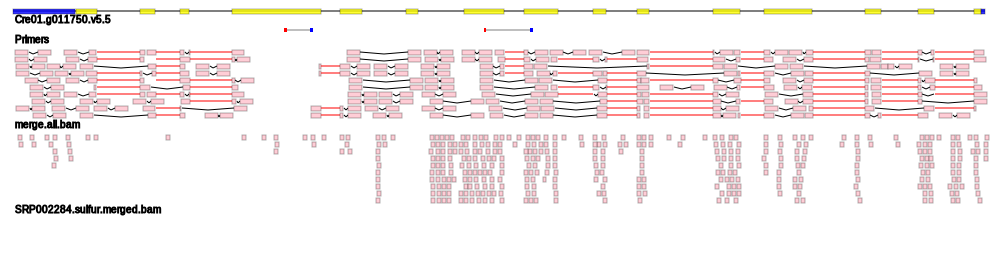

In [258]:
display(SVG('Cre01.g011750.v5.5.bamvisgene.svg'))

문제 발견! 만약에 insert size로 필터를 하고 싶을때 fragment size로 필터하려고 하면 문제가 생김. 왜냐면 spliced part 까지 포함해서 fragment size를 기록하므로 아무리 큰값으로 필터를 해봐야 여전히 insert size가 readlength 보다 작은 애들이 포함되게 된다. 저놈들이 그림에서 보이는 overlapped reads 웃긴건 저런놈들이 잇는 자리는 뭔가 일관되지 않다는것. 개떡같네 정말 ㅅㅂ. 일단 코드에 insert size를 정확하게 계산하는 부분을 넣도록 하자. 

In [7]:
genename = 'Cre03.g190250.v5.5'
chromosome, left, right = df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values[0]
print(chromosome, left, right) 
draw_alignment(genename)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


chromosome_3 5933677 5943525
samtools view /ref/analysis/Cre/tophat/merge_all/merge.all.bam chromosome_3:5933677-5943525 > temp.sam


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:60: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:103: PerformanceWarning: indexing past lexsort depth may impact performance.


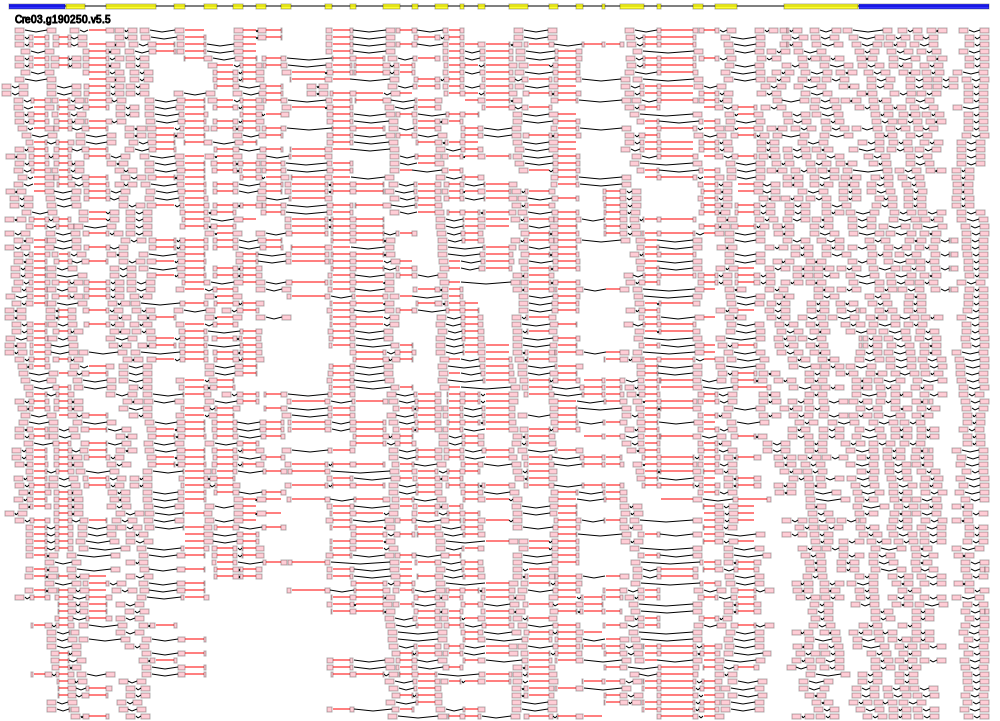

In [8]:
from IPython.display import SVG, display
display(SVG('./%s.%s.svg'%(genename,file_bam.split('/')[-1])))

In [132]:
df_sam_index.loc[(SRRID,READID)].values[0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


array(['SRR1617535.24084007', 16, 'scaffold_1', 4441356, 50, '50M', '*', 0,
       0, 'TTACTTGAAACTCATTATTTGTGATACTTTGGATTGGAATCTTATGGGTG',
       'JIGJJJJIIFJIIIJJJJJJJJJIHEJJJJJJJJJJJHHHHHFFFFFCCC', 'AS:i:-10',
       'XN:i:0', 'XM:i:2', 'XO:i:0', 'XG:i:0', 'NM:i:2', 'MD:Z:48A0A0',
       'YT:Z:UU'], dtype=object)

In [138]:

df_sam_index.loc[('SRR1617532','12153605')]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


KeyError: '12153605'

In [203]:
%save "RNAseq.bam.visualization.draw.py" 193-200

File `RNAseq.bam.visualization.draw.py` exists. Overwrite (y/[N])?  y
The following commands were written to file `RNAseq.bam.visualization.draw.py`:
import pandas as pd
import subprocess
import re
from __future__ import print_function
import numpy as np
file_bam = '/ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam'
#df_gene_gff = pd.read_pickle('../../genemodel_correction/tophat/df.cre.gff.gene.index.pickle')
df_gff_index = pd.read_pickle('/ref/analysis/pipelines/pandas_df/Esalsugineum_173_v1.0.gene.gff3.pandas.df.pk')
df_gff_ix = df_gff_index.reset_index().set_index(['genename','longest',2])

df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values
def draw_alignment(genename):
    print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-20 temp.sam > temp.sam.cut',shell=True)

    df_sam = pd.read_csv('temp.sam.cut',s

In [191]:
_ih[190]

u"file_gff = '/ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3'\ndf_gff   = pd.read_csv(file_gff,sep='\\t',skiprows=2,header=None)\n\n# For CRE\n#df_gff['genename'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))\n#df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:4]))\n\n\ndicT2G      = {} # transcript to genename\ndf_gff_mRNA = df_gff[(df_gff[2] == 'mRNA')]\ndef get_genename(x):\n    if x[2] == 'gene':\n        return None\n    key   = [y.split('=')[0] for y in x[8].split(';')]\n    value = [y.split('=')[1] for y in x[8].split(';')]\n    dic   = dict(zip(key,value))\n    return dic['Parent']\ndef get_transcript(x):\n    \n    \n    key   = [y.split('=')[0] for y in x[8].split(';')]\n    value = [y.split('=')[1] for y in x[8].split(';')]\n    dic   = dict(zip(key,value))\n    if x[2] == 'gene':\n        return None\n    elif x[2]

In [407]:
dic_fa['chromosome_1'][0:3500]

'GGGAACCAGCTACTAGATGGTTCGATTAGTCTTTCGCCCCTATACCCAAGTCTGAAAAGCGATTTGCACGTCAGCACATCTACGAGCCTCCACCAGAGTTTCCTCTGGCTTCACCCTGCTCAGGCATAGTTCACCATCTTTCGGGTCCCAACAGGTATGCTCGCACTCAAACCTTTCGTAGAAACAACATGGTCGGTCGATGGTGCAGGGTTTTACCCCATCCCACCAGTCAGGTTACTTGCGCTTACGGGTTTTCCACCCGCCAACTCGCATACATGTTAGACTCCTTGGTCCGTGTTTCAAGACGGGTCGATTGACGCTCTTCTGCCAGAATCTTTAGAGCACAGATCCCGAAGGACAAGGTACTCTTTACGCCTTGGTCGAGTCGGCGGCATCGGCCGGGTTACCTGGGTGGACCCAGCTTTTGTCCCGCCAACTCAACCCATTCTGACCAGCACCCAGCACATTCAACGGGCCGTTAGGACCGCTTAAGCCTGGGCGCACCTACGAGCGCCAATCGCTTCCCTCTCAACAATTTCAAGCACTTTTAACTCTCTTTTCAAAGTTCTTTTCATCTTTCCCTCACGGTACTTGTTCGCAGAAGGGATTTACCTCCAAATTAGGGCTGCATTCCCAAACAACCCGACTCGTGGAAAGCACTTCGTGGAAGGACTAAGCAGGAACCGACGGGGTTATCACCCTCTCTGACGCGGCATTCGATCCGACTTGAGTTCCGCCAGCCCTAGAAAGCGCTTCTCTAGACTACAATTCTCCAAAGGGAGATTTTCAAGTTGGGCTATTCCCGGTTCGCTCGCCGTTACTAGGGGAATCCTTGTTAGTTTCTTTTCCTCCGCTTATTGATATGCTTAAGTTCAGCGGGTAATCTTGCCTGAGCTCAGGTCGAGAAAATAGGGGTTTGCTTCGGCACAGGGCCAAAGTTCCTGGTTTGGGTCGACAAGCACAGCTCCAAGCCATCTACTAAAGCATTAGCAACGAGTT